# 債券

In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import polars as pl
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
from dividends_reinvestment_return import dividends_reinvestment_return

figsize = (1.618*6, 6)

In [2]:
path = '../../../data/row/usd_jpy_rate.csv'
usd_jpy_rate = pl.read_csv(path)
usd_jpy_rate = usd_jpy_rate.with_columns(
    pl.col("date").cast(pl.Date)
).rename({
    'date': 'Date'
}
).drop_nulls()
usd_jpy_rate

Date,usd_jpy_rate
date,f64
1973-01-04,301.1
1973-01-05,301.15
1973-01-08,302.25
1973-01-09,302.4
1973-01-10,301.55
…,…
2025-01-06,157.67
2025-01-07,157.5
2025-01-08,158.12


## 日本債券

In [38]:
ticker = '2510.T'
yf_ticker = yf.Ticker(ticker)
jp_histories = yf_ticker.history(period='max', interval='1d')
jp_df = pl.DataFrame({
    'Date': jp_histories.index,
    'Close': jp_histories['Close'],
    'Dividends': jp_histories['Dividends'],
})
jp_df = dividends_reinvestment_return(jp_df, initial_shares=1000)

Text(0.5, 1.0, 'NF国内債券 配当込みリターン (%)')

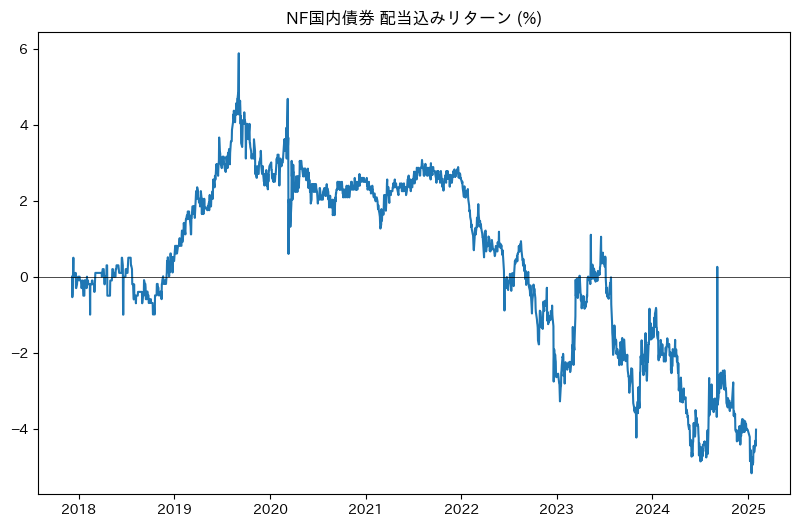

In [45]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(jp_df['Date'], jp_df['Return'])
ax.axhline(y=0, color='k', linewidth=0.5)
ax.set_title('NF国内債券 配当込みリターン (%)')

In [46]:
cagr = (jp_df['Value'][-1] / jp_df['Value'][0]) ** (250 / len(jp_df)) - 1

sd = np.std(jp_df['Close'].log().diff().fill_null(0).to_numpy())
sd_yearly = sd * np.sqrt(250)

sr = cagr / sd_yearly

print(f'CAGR: {cagr:.3%}')
print(f'Volatility: {sd_yearly:.3%}')
print(f'Sharpe Ratio: {sr:.3f}')

CAGR: -0.582%
Volatility: 4.339%
Sharpe Ratio: -0.134


## オーストラリア債券

In [ ]:
ticker = '2844.T'
yf_ticker = yf.Ticker(ticker)
australia_histories = yf_ticker.history(period='max', interval='1d')
australia_df = pl.DataFrame({
    'Date': australia_histories.index,
    'Close': australia_histories['Close'],
    'Dividends': australia_histories['Dividends'],
})
australia_df = dividends_reinvestment_return(australia_df, initial_shares=1000)

Text(0.5, 1.0, '上場豪債 配当込みリターン (円建て, %)')

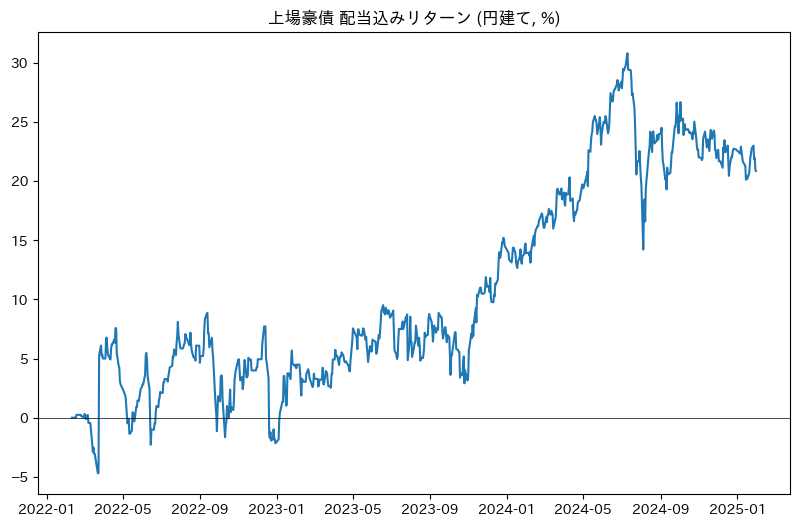

In [43]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(australia_df['Date'], australia_df['Return'])
ax.axhline(y=0, color='k', linewidth=0.5)
ax.set_title('上場豪債 配当込みリターン (円建て, %)')

In [7]:
cagr = (australia_df['Value'][-1] / australia_df['Value'][0]) ** (250 / len(australia_df)) - 1

sd = np.std(australia_df['Close'].log().diff().fill_null(0).to_numpy())
sd_yearly = sd * np.sqrt(250)

sr = cagr / sd_yearly

print(f'CAGR: {cagr:.3%}')
print(f'Volatility: {sd_yearly:.3%}')
print(f'Sharpe Ratio: {sr:.3f}')

CAGR: 6.723%
Volatility: 14.158%
Sharpe Ratio: 0.475


## シンガポール債券

In [35]:
ticker = ['A35.SI', 'SGDJPY=X']
yf_ticker = yf.Tickers(ticker)
sing_histories = yf_ticker.history(period='max', interval='1d')
sing_df = pl.DataFrame({
    'Date': sing_histories.index,
    'Close': sing_histories['Close']['A35.SI'],
    'Dividends': sing_histories['Dividends']['A35.SI'],
    'Rate': sing_histories['Close']['SGDJPY=X'],
}).with_columns([
    pl.col('Date').cast(pl.Date),
    pl.col('Close') * pl.col('Rate').alias('Close')
]).drop_nulls()
# sing_df = sing_df.join(usd_jpy_rate, on='Date', how='left')
# sing_df = sing_df.with_columns([
#     (pl.col('Close') * pl.col('usd_jpy_rate')).alias('Close'),
# ]).drop_nulls()
sing_df = dividends_reinvestment_return(sing_df, initial_shares=1000)

[*********************100%***********************]  2 of 2 completed


In [36]:
sing_df

Date,Close,Dividends,Rate,Shares,Value,LogValue,LogReturn,Return
date,f64,f64,f64,f64,f64,f64,f64,f64
2008-01-02,60.838544,0.0,75.900002,1000.0,60838.544304,11.015979,0.0,0.0
2008-01-03,61.352844,0.0,76.330002,1000.0,61352.844268,11.024397,0.008418,0.845352
2008-01-04,61.182876,0.0,75.699997,1000.0,61182.876385,11.021623,0.005644,0.565977
2008-01-07,61.798752,0.0,76.129997,1000.0,61798.751756,11.031638,0.01566,1.578288
2008-01-08,61.717578,0.0,76.029999,1000.0,61717.577697,11.030324,0.014345,1.444863
…,…,…,…,…,…,…,…,…
2025-01-23,122.576042,0.0,115.419998,1000.0,122576.042238,11.716487,0.700508,101.477605
2025-01-24,122.734976,0.0,115.136002,1000.0,122734.975935,11.717783,0.701804,101.738844
2025-01-27,123.233172,0.0,115.495003,1000.0,123233.171565,11.721834,0.705855,102.557725


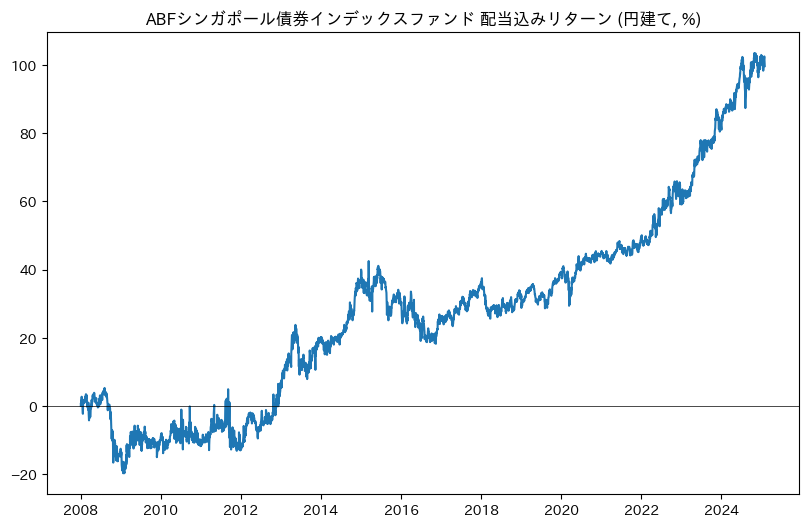

In [37]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(sing_df['Date'], sing_df['Return'])
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('ABFシンガポール債券インデックスファンド 配当込みリターン (円建て, %)')
plt.show()

In [31]:
cagr = (sing_df['Value'][-1] / sing_df['Value'][0]) ** (250 / len(sing_df)) - 1

sd = np.std(sing_df['Close'].log().diff().fill_null(0).to_numpy())
sd_yearly = sd * np.sqrt(250)

sr = cagr / sd_yearly

print(f'CAGR: {cagr:.3%}')
print(f'Volatility: {sd_yearly:.3%}')
print(f'Sharpe Ratio: {sr:.3f}')

CAGR: 4.141%
Volatility: 17.018%
Sharpe Ratio: 0.243


## NF Dev

In [ ]:
ticker = '2511.T'
yf_ticker = yf.Ticker(ticker)
nf_dev_histories = yf_ticker.history(period='max', interval='1d')
nf_dev_df = pl.DataFrame({
    'Date': nf_dev_histories.index,
    'Close': nf_dev_histories['Close'],
    'Dividends': nf_dev_histories['Dividends'],
})
nf_dev_df = dividends_reinvestment_return(nf_dev_df, initial_shares=1000)

Text(0.5, 1.0, 'NF外債ヘッジ無し')

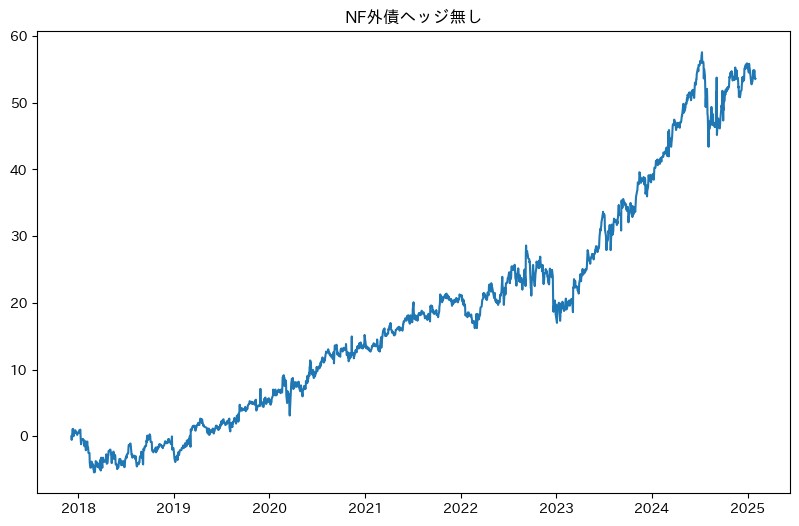

In [96]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(nf_dev_df['Date'], nf_dev_df['Return'], label='nf_dev')
ax.set_title('NF外債ヘッジ無し')

$$
\begin{aligned}
CAGR &= \left(\frac{Value_T}{Value_1} \right)^{1/t} - 1\\
t &= \frac{mo}{\text{12}} \\
\end{aligned}
$$

In [ ]:
cagr = (nf_dev_df['Value'][-1] / nf_dev_df['Value'][0]) ** (250 / len(nf_dev_df)) - 1

sd = np.std(nf_dev_df['Close'].log().diff().fill_null(0).to_numpy())
sd_yearly = sd * np.sqrt(250)

sr = cagr / sd_yearly

print(f'CAGR: {cagr:.3%}')
print(f'Volatility: {sd_yearly:.3%}')
print(f'Sharpe Ratio: {sr:.3f}')

CAGR: 6.283%
Volatility: 9.124%
Sharpe Ratio: 0.689


## LEMB

In [ ]:
ticker = 'LEMB'
yf_ticker = yf.Ticker(ticker)
lemb_histories = yf_ticker.history(period='max', interval='1d')
lemb_df = pl.DataFrame({
    'Date': lemb_histories.index,
    'Close': lemb_histories['Close'],
    'Dividends': lemb_histories['Dividends'],
}).with_columns([
    pl.col('Date').cast(pl.Date),
])
lemb_df = lemb_df.join(usd_jpy_rate, on='Date', how='left')
lemb_df = lemb_df.with_columns([
    (pl.col('Close') * pl.col('usd_jpy_rate')).alias('Close'),
]).drop_nulls()
lemb_df = dividends_reinvestment_return(lemb_df, initial_shares=1000)

In [102]:
lemb_df

Date,Close,Dividends,usd_jpy_rate,Shares,Value,LogValue,LogReturn,Return
date,f64,f64,f64,f64,f64,f64,f64,f64
2011-10-20,3004.000838,0.0,76.685,1000.0,3.0040e6,14.915456,0.0,0.0
2011-10-21,2970.037767,0.0,76.71,1000.0,2.9700e6,14.904085,-0.01137,-1.130595
2011-10-24,2923.288749,0.0,76.235,1000.0,2.9233e6,14.88822,-0.027236,-2.68682
2011-10-25,2921.575717,0.0,76.115,1000.0,2.9216e6,14.887634,-0.027822,-2.743845
2011-10-26,2902.563475,0.0,75.92,1000.0,2.9026e6,14.881105,-0.034351,-3.376742
…,…,…,…,…,…,…,…,…
2024-12-30,5715.61812,0.0,157.89,1000.0,5.7156e6,15.558713,0.643257,90.266862
2025-01-06,5707.65412,0.0,157.67,1000.0,5.7077e6,15.557319,0.641863,90.001749
2025-01-07,5701.50012,0.0,157.5,1000.0,5.7015e6,15.55624,0.640784,89.796888


Text(0.5, 1.0, 'iシェアーズ JPM 現地通貨新興国債券 ETF')

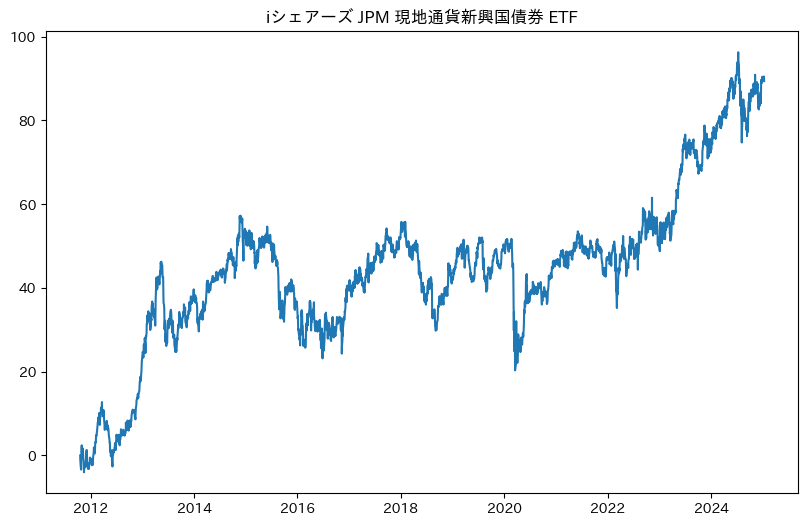

In [106]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(lemb_df['Date'], lemb_df['Return'], label='LEMB')
ax.set_title('iシェアーズ JPM 現地通貨新興国債券 ETF')

In [110]:
cagr = (lemb_df['Value'][-1] / lemb_df['Value'][0]) ** (250 / len(lemb_df)) - 1

sd = np.std(lemb_df['Close'].log().diff().fill_null(0).to_numpy())
sd_yearly = sd * np.sqrt(250)

sr = cagr / sd_yearly

print(f'CAGR: {cagr:.3%}')
print(f'Volatility: {sd_yearly:.3%}')
print(f'Sharpe Ratio: {sr:.3f}')

CAGR: 5.242%
Volatility: 13.138%
Sharpe Ratio: 0.399


## NF EM Bond ETF

In [56]:
ticker = '2519.T'
yf_ticker = yf.Ticker(ticker)
nf_em_histories = yf_ticker.history(period='max', interval='1d')
nf_em_df = pl.DataFrame({
    'Date': nf_em_histories.index,
    'Close': nf_em_histories['Close'],
    'Dividends': nf_em_histories['Dividends'],
})
nf_em_df = dividends_reinvestment_return(nf_em_df, initial_shares=1000)

Text(0.5, 1.0, 'NF新興国債ヘッジ無')

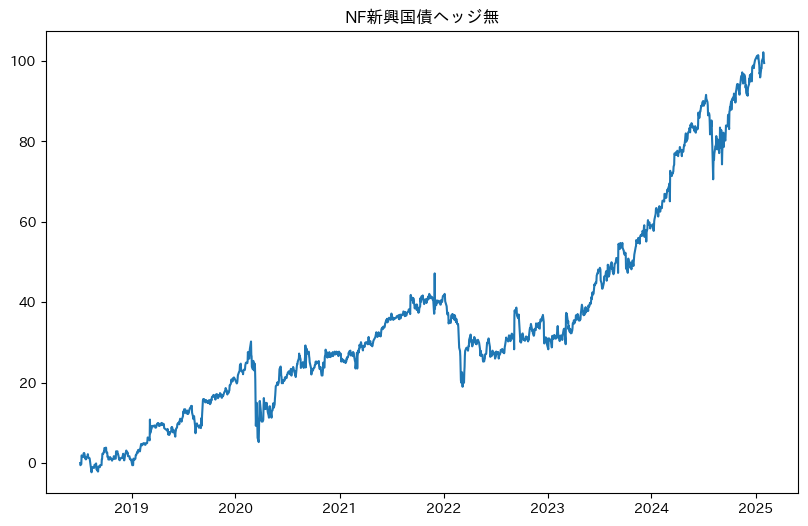

In [57]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(nf_em_df['Date'], nf_em_df['Return'], label='nf_em')
ax.set_title('NF新興国債ヘッジ無')

In [58]:
cagr = (nf_em_df['Value'][-1] / nf_em_df['Value'][0]) ** (250 / len(nf_em_df)) - 1

sd = np.std(nf_em_df['Close'].log().diff().fill_null(0).to_numpy())
sd_yearly = sd * np.sqrt(250)

sr = cagr / sd_yearly

print(f'CAGR: {cagr:.3%}')
print(f'Volatility: {sd_yearly:.3%}')
print(f'Sharpe Ratio: {sr:.3f}')

CAGR: 11.321%
Volatility: 12.834%
Sharpe Ratio: 0.882


## 比較

In [48]:
tickers = ['2510.T', '2844.T', 'A35.SI', '2511.T', 'LEMB', '2519.T', 'SGDJPY=X']
yf_tickers = yf.Tickers(tickers)
histories = yf_tickers.history(period='max', interval='1d')
df = pl.DataFrame({
    'Date': histories.index,
    'nf_jp': histories['Close']['2510.T'],
    'au': histories['Close']['2844.T'],
    'sing': histories['Close']['A35.SI']*histories['Close']['SGDJPY=X'],
    'nf_dev': histories['Close']['2511.T'],
    'lemb': histories['Close']['LEMB'],
    'nf_em': histories['Close']['2519.T'],
}).drop_nulls()
df = df.with_columns([pl.col('Date').cast(pl.Date)]).join(usd_jpy_rate, on='Date', how='left').drop_nulls()
df = df.with_columns([
    (pl.col('lemb') * pl.col('usd_jpy_rate')).alias('lemb'),
])
df

[*********************100%***********************]  7 of 7 completed


Date,nf_jp,au,sing,nf_dev,lemb,nf_em,usd_jpy_rate
date,f64,f64,f64,f64,f64,f64,f64
2022-02-10,963.849854,4548.655273,91.136705,922.505615,4514.852471,885.026367,115.595
2022-02-14,962.473267,4548.655273,90.633994,915.066772,4474.889089,874.180542,115.41
2022-02-15,962.374817,4548.655273,90.362612,912.403503,4511.857591,879.386536,115.345
2022-02-16,960.506531,4549.019043,90.64456,913.872803,4538.297324,874.614319,115.645
2022-02-17,959.130005,4559.572266,90.426937,913.046387,4521.375161,874.614319,115.3
…,…,…,…,…,…,…,…
2024-12-30,902.0,5092.0,123.493022,1118.5,5715.61812,1121.0,157.89
2025-01-06,900.400024,5077.0,121.995131,1108.5,5707.65412,1127.0,157.67
2025-01-07,900.200012,5101.0,123.178975,1118.0,5701.50012,1127.0,157.5


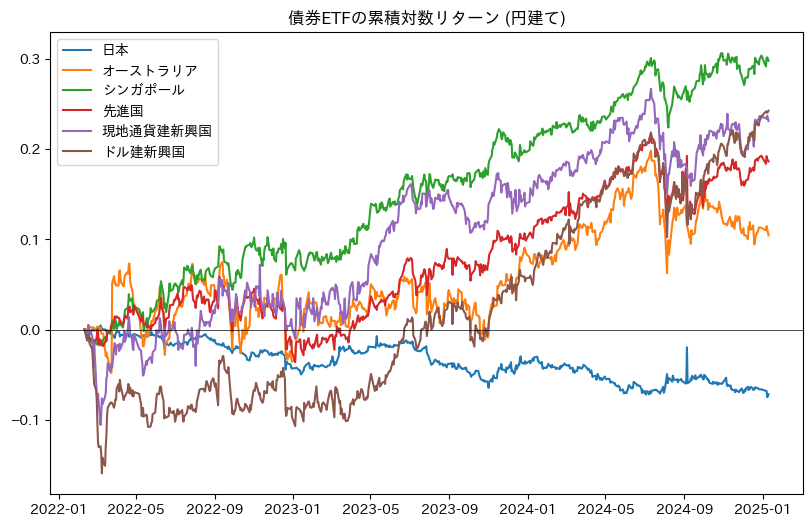

In [54]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(df['Date'], df['nf_jp'].log()-df['nf_jp'].log()[0], label='日本')
ax.plot(df['Date'], df['au'].log()-df['au'].log()[0], label='オーストラリア')
ax.plot(df['Date'], df['sing'].log()-df['sing'].log()[0], label='シンガポール')
ax.plot(df['Date'], df['nf_dev'].log()-df['nf_dev'].log()[0], label='先進国')
ax.plot(df['Date'], df['lemb'].log()-df['lemb'].log()[0], label='現地通貨建新興国')
ax.plot(df['Date'], df['nf_em'].log()-df['nf_em'].log()[0], label='ドル建新興国')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('債券ETFの累積対数リターン (円建て)')
ax.legend()

Text(0, 0.5, 'nf_em')

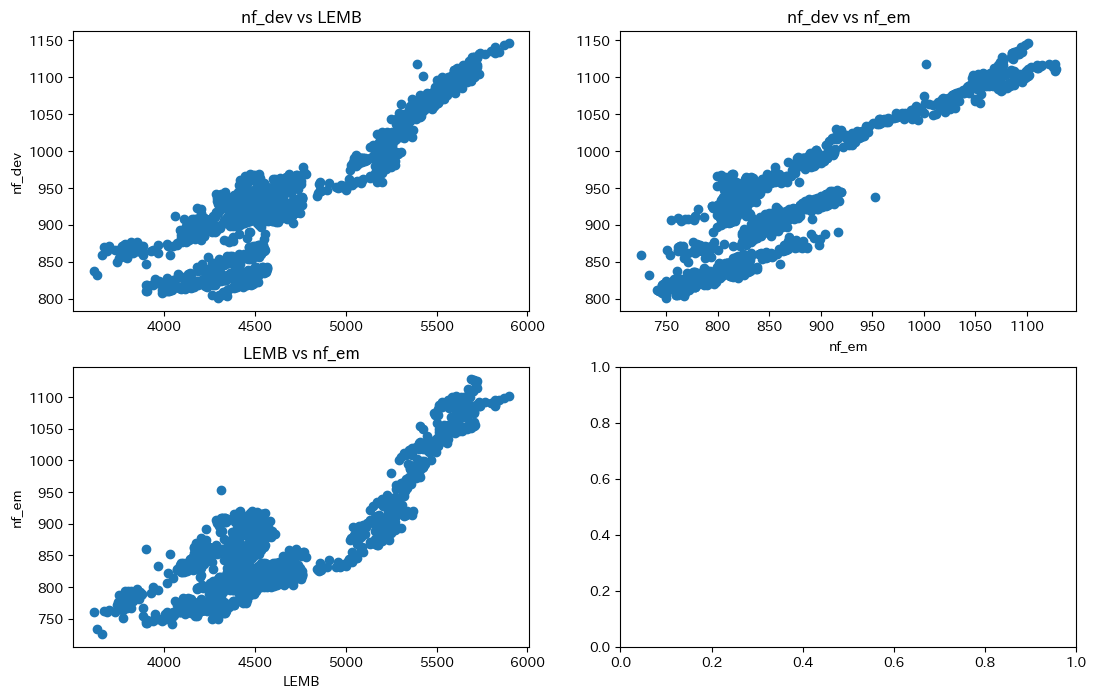

In [116]:
fig, ax = plt.subplots(2, 2, figsize=(1.618*8, 8))
ax[0, 0].set_title('nf_dev vs LEMB')
ax[0, 0].scatter(df['lemb'], df['nf_dev'], label='nf_dev vs LEMB')
ax[0, 0].set_ylabel('nf_dev')
ax[0, 1].set_title('nf_dev vs nf_em')
ax[0, 1].scatter(df['nf_em'], df['nf_dev'], label='nf_dev vs nf_em')
ax[0, 1].set_xlabel('nf_em')
ax[1, 0].set_title('LEMB vs nf_em')
ax[1, 0].scatter(df['lemb'], df['nf_em'], label='LEMB vs nf_em')
ax[1, 0].set_xlabel('LEMB')
ax[1, 0].set_ylabel('nf_em')

## Regressions

In [ ]:
df = df.with_columns(df.with_row_count()) # トレンド項を追加

/tmp/ipykernel_2657/1497306967.py:1: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df = df.with_columns(df.with_row_count())


In [119]:
y, X = dmatrices('I(nf_dev.diff()) ~ I(nf_em.diff()) + row_nr', data=df.to_pandas(), return_type='dataframe')
model = sm.OLS(y, X)
result = model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       I(nf_dev.diff())   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     37.23
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           1.62e-16
Time:                        17:06:32   Log-Likelihood:                -4636.0
No. Observations:                1533   AIC:                             9278.
Df Residuals:                    1530   BIC:                             9294.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0771      0.185     

In [120]:
y, X = dmatrices('I(nf_dev.diff()) ~ I(lemb.diff()) + row_nr', data=df.to_pandas(), return_type='dataframe')
model = sm.OLS(y, X)
result = model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       I(nf_dev.diff())   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     65.12
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           7.21e-28
Time:                        17:06:51   Log-Likelihood:                -4723.3
No. Observations:                1533   AIC:                             9453.
Df Residuals:                    1530   BIC:                             9469.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0622      0.179      0.

In [121]:
y, X = dmatrices('I(lemb.diff()) ~ I(nf_em.diff()) + row_nr', data=df.to_pandas(), return_type='dataframe')
model = sm.OLS(y, X)
result = model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         I(lemb.diff())   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     22.32
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           2.79e-10
Time:                        17:07:03   Log-Likelihood:                -7675.2
No. Observations:                1533   AIC:                         1.536e+04
Df Residuals:                    1530   BIC:                         1.537e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0196      1.554     